In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA  # Import from the updated module
from time import time


In [2]:
production_ice_cream = pd.read_csv(
    r'D:\Time series analysis\ice_cream.csv',
    parse_dates=[0],
    index_col=0,
    date_format='%Y-%m-%d'  # Use date_format instead of date_parser if applicable
)


In [3]:
production_ice_cream.squeeze()

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: IPN31152N, Length: 577, dtype: float64

In [4]:
# For Series
# For renaming the column 'old_column_name' to 'production' in a DataFrame
production_ice_cream.rename(columns={'IPN31152N': 'production'}, inplace=True)
production_ice_cream


,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


In [5]:
#infer the frequency of the data
production_ice_cream=production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [6]:
#just get a data from 2010 onwards
start_date=pd.to_datetime('2010-01-01')
production_ice_cream=production_ice_cream[start_date:]

In [7]:
production_ice_cream.head()

,production
DATE,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


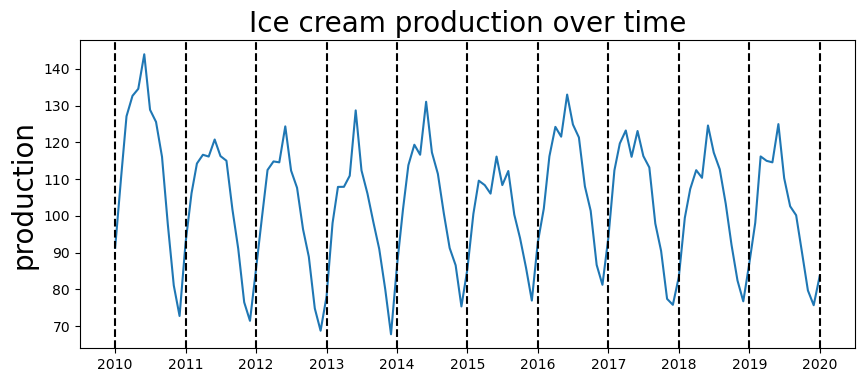

In [8]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream.production)
plt.title('Ice cream production over time',fontsize=20)
plt.ylabel('production',fontsize=20)
for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

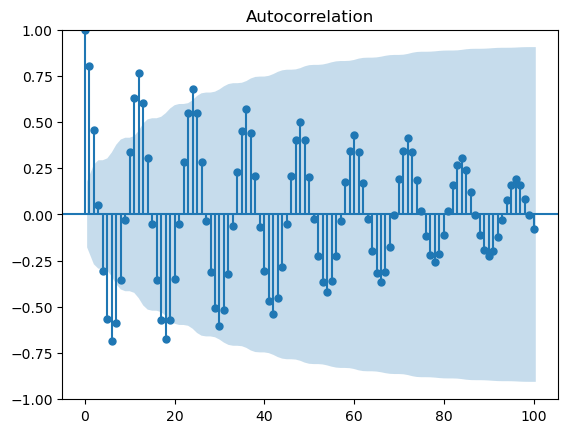

In [9]:
acf_plot=plot_acf(production_ice_cream.production,lags=100)

## Based on decaying ACF, we are likely dealing with an Auto Regressive process

## PACF

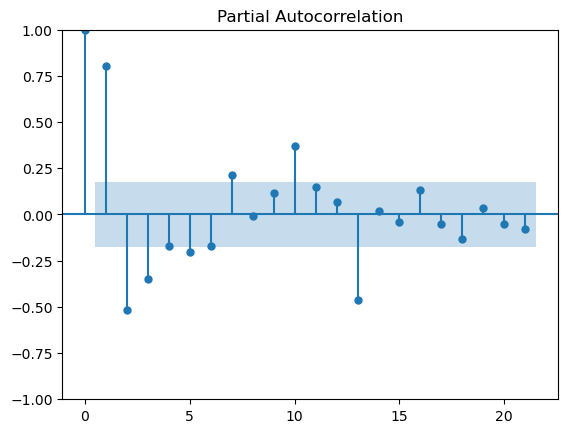

In [10]:
pacf_plot=plot_pacf(production_ice_cream.production)

## Based on PACF,we should start with an Auto Regressive model with lags 1,2,3,10,13

## Get training and testing sets

In [11]:
train_end=datetime(2018,12,1)#training data from 2010 to 2018 last
test_end=datetime(2019,12,1)#test data from 2019 satring to 2019 ending
train_data=production_ice_cream[:train_end]
test_data=production_ice_cream[train_end+timedelta(days=1):test_end]

## Fit the AR model

In [12]:
#create the model
model=ARIMA(train_data,order=(3,0,0))

In [13]:
start=time()
model_fit=model.fit()
end=time()
print('model fitting time',end-start)

model fitting time 0.23184704780578613


In [14]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Sat, 10 Aug 2024   AIC                            758.170
Time:                        19:58:42   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

## Here from the table if respective lags p<0.5 then as much as it is lower then its significance is much higher and if p>0.5 the it is not that much of significant

## we consider only lag1 and lag3 cause lag2 p value more than 0.5

In [15]:
#get predictions start and end dates
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [16]:
#get the predictions and residuals
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data-predictions

In [17]:
print(test_data.head())

            production
DATE                  
2019-01-01     86.9988
2019-02-01     98.1116
2019-03-01    116.1718
2019-04-01    114.9703
2019-05-01    114.5613


In [18]:
print(predictions.head())

2019-01-01     81.236249
2019-02-01     90.140510
2019-03-01    101.523172
2019-04-01    111.164049
2019-05-01    117.060582
Freq: MS, Name: predicted_mean, dtype: float64


In [19]:
print(residuals.head())

            production  2019-01-01 00:00:00  2019-02-01 00:00:00  \
DATE                                                               
2019-01-01         NaN                  NaN                  NaN   
2019-02-01         NaN                  NaN                  NaN   
2019-03-01         NaN                  NaN                  NaN   
2019-04-01         NaN                  NaN                  NaN   
2019-05-01         NaN                  NaN                  NaN   

            2019-03-01 00:00:00  2019-04-01 00:00:00  2019-05-01 00:00:00  \
DATE                                                                        
2019-01-01                  NaN                  NaN                  NaN   
2019-02-01                  NaN                  NaN                  NaN   
2019-03-01                  NaN                  NaN                  NaN   
2019-04-01                  NaN                  NaN                  NaN   
2019-05-01                  NaN                  NaN         

In [20]:
# Ensure that the indices are aligned
predictions = predictions.squeeze()  # Convert predictions to Series if it's not already
test_data = test_data.squeeze()      # Convert test_data to Series if it's not already

# Check the indices
print(test_data.index)
print(predictions.index)


DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')
DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')


In [21]:
# Calculate residuals
residuals = test_data - predictions
print(residuals.head())  # This should show the differences between actual and predicted values


DATE
2019-01-01     5.762551
2019-02-01     7.971090
2019-03-01    14.648628
2019-04-01     3.806251
2019-05-01    -2.499282
Freq: MS, dtype: float64


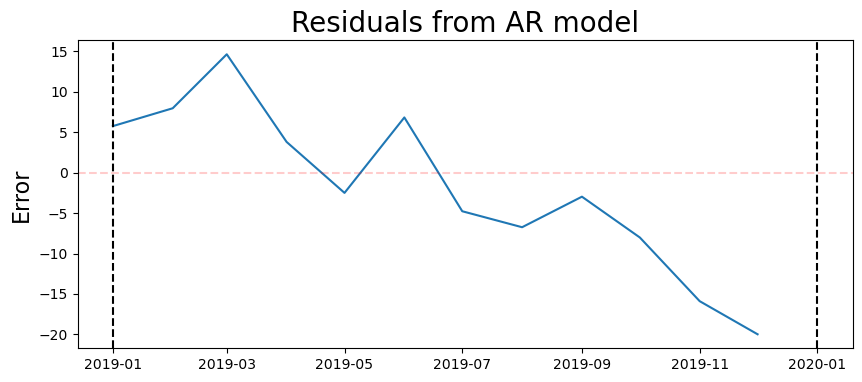

In [22]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model',fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

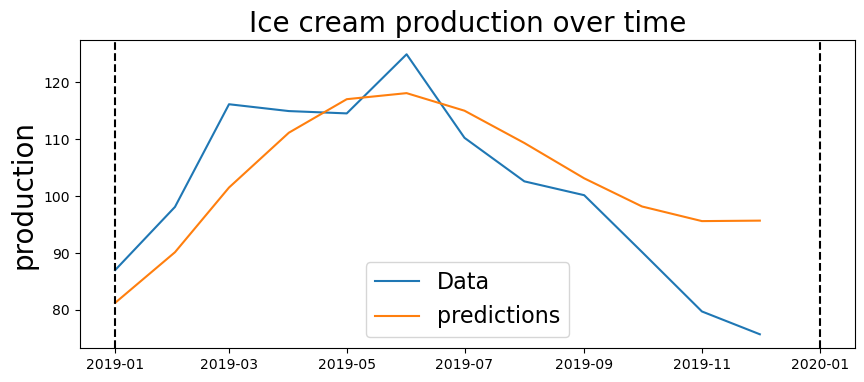

In [23]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','predictions'),fontsize=16)

plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('production',fontsize=20)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

In [24]:
print('Mean absolute percent error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error: 0.0895


In [25]:
print('Root mean sqaure Error', np.sqrt(np.mean(residuals**2)))

Root mean sqaure Error 9.88415874939623


## Evaluating Time series model

In [26]:
train_end=datetime(2016,12,1)#training data from 2010 to 2018 last
test_end=datetime(2019,12,1)#test data from 2019 satring to 2019 ending
train_data=production_ice_cream[:train_end]
test_data=production_ice_cream[train_end+timedelta(days=1):test_end]

In [27]:
#create the model
model=ARIMA(train_data,order=(3,0,0))

In [28]:
start=time()
model_fit=model.fit()
end=time()
print('model fitting time',end-start)

model fitting time 0.20215082168579102


In [29]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Sat, 10 Aug 2024   AIC                            598.015
Time:                        19:58:45   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

In [30]:
#get predictions start and end dates
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [31]:
#get the predictions and residuals
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data-predictions

In [32]:
# Ensure that the indices are aligned
predictions = predictions.squeeze()  # Convert predictions to Series if it's not already
test_data = test_data.squeeze()      # Convert test_data to Series if it's not already

# Check the indices
print(test_data.index)
print(predictions.index)


DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')
DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
              

In [33]:
# Calculate residuals
residuals = test_data - predictions
print(residuals.head())  # This should show the differences between actual and predicted values


DATE
2017-01-01    12.338211
2017-02-01    23.682390
2017-03-01    21.755543
2017-04-01    16.216469
2017-05-01     2.723297
Freq: MS, dtype: float64


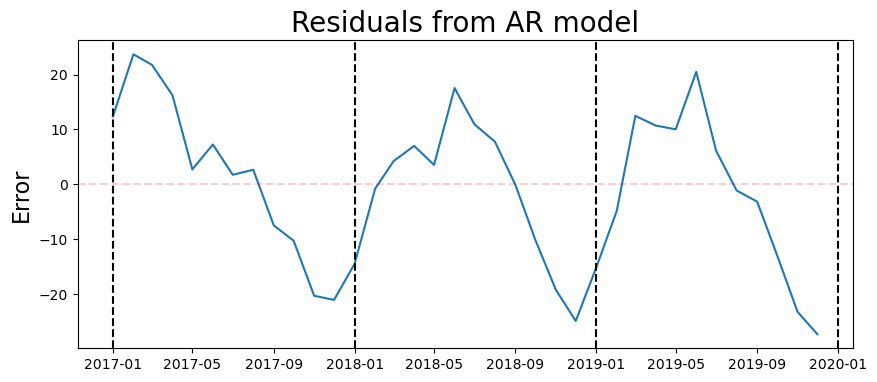

In [34]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model',fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

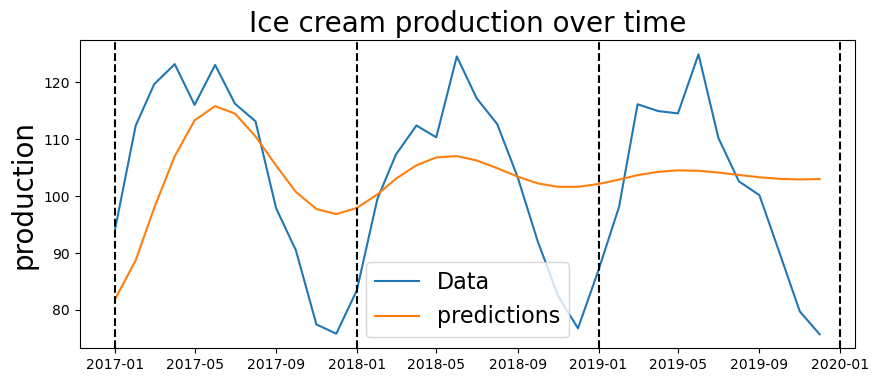

In [35]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','predictions'),fontsize=16)

plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('production',fontsize=20)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

In [36]:
print('Mean absolute percent error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error: 0.1211


In [37]:
print('Root mean sqaure Error', np.sqrt(np.mean(residuals**2)))

Root mean sqaure Error 13.890102330332478


## Rolling forecast origin

## Idea : Predict one month in advance each time

## Train on month 1,2,....k-3 -> predict month k-2

## Train on month 1,2,....k-2 -> predict month k-1

## Train on month 1,2,....k-1 -> predict month k

## ....

## Average all predictions

In [38]:
prediction_rolling = pd.Series()
for end_date in test_data.index:
    train_data=production_ice_cream[:end_date-timedelta(days=1)]
    model=ARIMA(train_data,order=(3,0,0))
    model_fit=model.fit()
    pred=model_fit.predict(end_date)
    prediction_rolling.loc[end_date]=pred.loc[end_date]

In [39]:
residuals_rolling=test_data-prediction_rolling

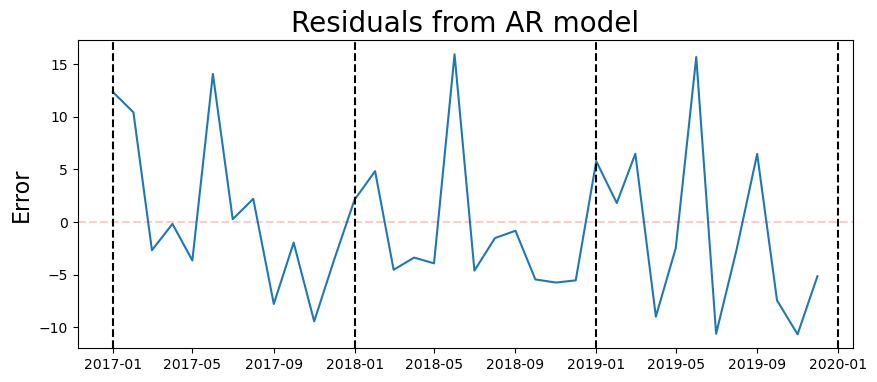

In [40]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR model',fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

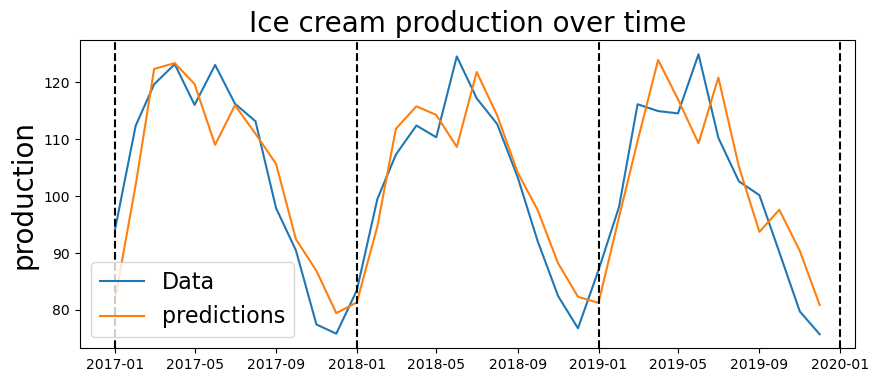

In [41]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(prediction_rolling)
plt.legend(('Data','predictions'),fontsize=16)

plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('production',fontsize=20)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

In [42]:
print('Mean absolute percent error:', round(np.mean(abs(residuals_rolling/test_data)),4))

Mean absolute percent error: 0.0582


In [43]:
print('Root mean sqaure Error', np.sqrt(np.mean(residuals_rolling**2)))

Root mean sqaure Error 7.196513635978139
